# Neural Network From Scratch - Complete Implementation

In this notebook, you'll implement a neural network from the ground up using only NumPy. You'll understand:
- Forward propagation
- Backpropagation & gradient descent
- Loss functions & activation functions
- Training on a real dataset

**Learning Approach**: First implement individual functions, then build them into a complete NeuralNetwork class.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Part 1: Activation Functions

Activation functions introduce non-linearity into the network, allowing it to learn complex patterns.

**Key Concepts**:
- **Sigmoid**: Outputs between 0 and 1, useful for binary classification
- **ReLU**: Outputs max(0, x), prevents vanishing gradients
- **Tanh**: Outputs between -1 and 1, zero-centered

You'll implement both the functions AND their derivatives (needed for backpropagation).


**Basically the Activation Functions are there to Help our Neural Network to stop acting Linearly, and Add non-Linearity to it, with different functions as we learned Here**

In [8]:
# 1. SIGMOID ACTIVATION
def sigmoid(z):
    """
    Compute sigmoid activation.
    Formula: σ(z) = 1 / (1 + e^(-z))

    Args:
        z: Input array of any shape
    Returns:
        Sigmoid of z, same shape as z
    """
    return 1 / (1 + np.exp(-z))
    

def sigmoid_derivative(z):
    """
    Compute derivative of sigmoid.
    Formula: σ'(z) = σ(z) * (1 - σ(z))
    
    Args:
        z: Input array (can be pre-computed sigmoid values)
    Returns:
        Derivative of sigmoid
    """
    s = sigmoid(z)
    return s * (1 - s)


# Test sigmoid
test_z = np.array([-2, -1, 0, 1, 2])
test_z_derivative = np.array([-10, -1, 0, 1, 10])
print("\nSigmoid test:")
print(f"Input: {test_z}")
print(f"Sigmoid: {sigmoid(test_z)}")
print(f"Derivative: {sigmoid_derivative(test_z_derivative)}")


Sigmoid test:
Sigmoid test:
Input: [-2 -1  0  1  2]
Sigmoid: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
Derivative: [4.53958077e-05 1.96611933e-01 2.50000000e-01 1.96611933e-01
 4.53958077e-05]


In [10]:
# 2. ReLU ACTIVATION
def relu(z):
    """
    Compute ReLU activation.
    Formula: ReLU(z) = max(0, z)
    
    Args:
        z: Input array
    Returns:
        ReLU of z
    """
    return np.maximum(0, z)


def relu_derivative(z):
    """
    Compute derivative of ReLU.
    Formula: ReLU'(z) = 1 if z > 0, else 0
    
    Args:
        z: Input array
    Returns:
        Derivative of ReLU
    """
    ### YOUR CODE HERE ###
    return (z > 0).astype(float)


# Test ReLU
print("\nReLU test:")
print(f"Input: {test_z}")
print(f"ReLU: {relu(test_z)}")
print(f"Derivative: {relu_derivative(test_z)}")


ReLU test:
Input: [-2 -1  0  1  2]
ReLU: [0 0 0 1 2]
Derivative: [0. 0. 0. 1. 1.]


In [12]:
# 3. TANH ACTIVATION
def tanh(z):
    """
    Compute tanh activation.
    Formula: tanh(z) = (e^z - e^(-z)) / (e^z + e^(-z))
    
    Args:
        z: Input array
    Returns:
        Tanh of z
    """
    return np.tanh(z)


def tanh_derivative(z):
    """
    Compute derivative of tanh.
    Formula: tanh'(z) = 1 - tanh(z)^2
    
    Args:
        z: Input array
    Returns:
        Derivative of tanh
    """
    t = tanh(z)
    return 1 - t**2


# Test Tanh
print("\nTanh test:")
print(f"Input: {test_z}")
print(f"Tanh: {tanh(test_z)}")
print(f"Derivative: {tanh_derivative(test_z)}")


Tanh test:
Input: [-2 -1  0  1  2]
Tanh: [-0.96402758 -0.76159416  0.          0.76159416  0.96402758]
Derivative: [0.07065082 0.41997434 1.         0.41997434 0.07065082]


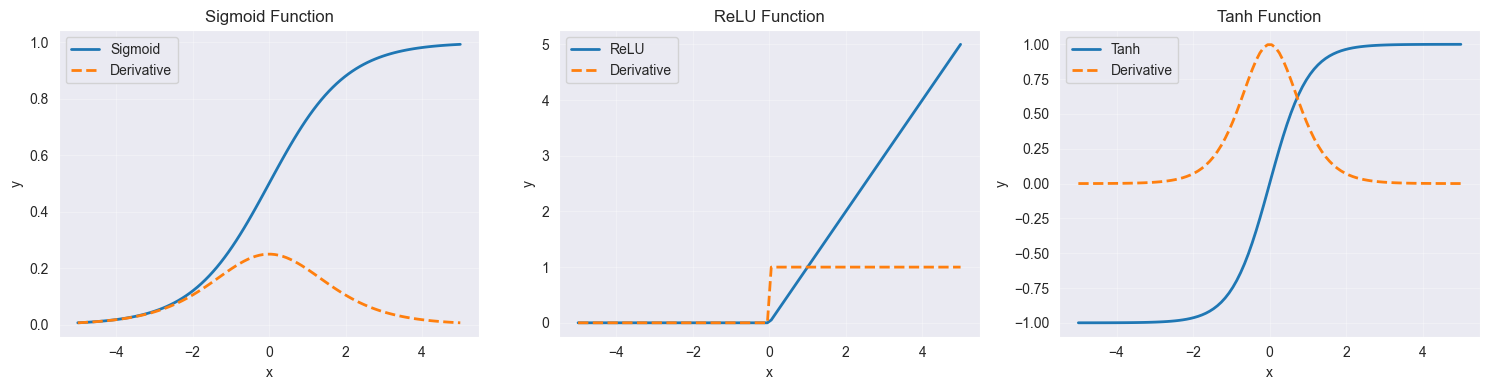

In [13]:
# Visualize activation functions
x = np.linspace(-5, 5, 100)

plt.figure(figsize=(15, 4))

# Sigmoid
plt.subplot(1, 3, 1)
plt.plot(x, sigmoid(x), label='Sigmoid', linewidth=2)
plt.plot(x, sigmoid_derivative(x), label='Derivative', linewidth=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('y')

# ReLU
plt.subplot(1, 3, 2)
plt.plot(x, relu(x), label='ReLU', linewidth=2)
plt.plot(x, relu_derivative(x), label='Derivative', linewidth=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('ReLU Function')
plt.xlabel('x')
plt.ylabel('y')

# Tanh
plt.subplot(1, 3, 3)
plt.plot(x, tanh(x), label='Tanh', linewidth=2)
plt.plot(x, tanh_derivative(x), label='Derivative', linewidth=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Tanh Function')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

## Part 2: Loss Functions

Loss functions measure how far our predictions are from the true values.

**Key Concepts**:
- **Binary Cross-Entropy**: For binary classification (0 or 1)
- **Mean Squared Error**: For regression or can be used for classification
- We need both the loss value AND its derivative for backpropagation

In [23]:
def binary_cross_entropy(y_true, y_pred, epsilon=1e-15):
    """
    Compute binary cross-entropy loss.
    Formula: L = -1/m * Σ[y*log(ŷ) + (1-y)*log(1-ŷ)]
    
    Args:
        y_true: True labels (m, 1)
        y_pred: Predicted probabilities (m, 1)
        epsilon: Small value to avoid log(0)
    Returns:
        Average loss across all samples
    """
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    m = y_true.shape[0]
    loss = -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss


def binary_cross_entropy_derivative(y_true, y_pred, epsilon=1e-15):
    """
    Compute derivative of binary cross-entropy with respect to predictions.
    Formula: dL/dŷ = -(y/ŷ - (1-y)/(1-ŷ))
    
    Args:
        y_true: True labels (m, 1)
        y_pred: Predicted probabilities (m, 1)
        epsilon: Small value to avoid division by zero
    Returns:
        Gradient of loss with respect to predictions
    """
    ### YOUR CODE HERE ###
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(y_true / y_pred - (1 - y_true) / (1 - y_pred))


# Test BCE
y_true_test = np.array([[1], [0], [1], [0]])
y_pred_test = np.array([[0.5], [0.5], [0.5], [0.5]])
print("Binary Cross-Entropy test:")
print(f"True labels: {y_true_test.T}")
print(f"Predictions: {y_pred_test.T}")
print(f"BCE Loss: {binary_cross_entropy(y_true_test, y_pred_test):.4f}")
print(f"BCE Derivative shape: {binary_cross_entropy_derivative(y_true_test, y_pred_test).shape}")

Binary Cross-Entropy test:
True labels: [[1 0 1 0]]
Predictions: [[0.5 0.5 0.5 0.5]]
BCE Loss: 0.6931
BCE Derivative shape: (4, 1)


In [24]:
def mean_squared_error(y_true, y_pred):
    """
    Compute mean squared error.
    Formula: L = 1/(2m) * Σ(y - ŷ)^2
    
    Args:
        y_true: True labels (m, 1)
        y_pred: Predicted values (m, 1)
    Returns:
        Average MSE loss
    """
    m = y_true.shape[0]
    loss = 1/(2*m) * np.sum((y_true - y_pred)**2)
    return loss


def mean_squared_error_derivative(y_true, y_pred):
    """
    Compute derivative of MSE with respect to predictions.
    Formula: dL/dŷ = -(y - ŷ) / m
    
    Args:
        y_true: True labels (m, 1)
        y_pred: Predicted values (m, 1)
    Returns:
        Gradient of loss
    """
    m = y_true.shape[0]
    return -(y_true - y_pred) / m


# Test MSE
print("\nMean Squared Error test:")
print(f"MSE Loss: {mean_squared_error(y_true_test, y_pred_test):.4f}")
print(f"MSE Derivative shape: {mean_squared_error_derivative(y_true_test, y_pred_test).shape}")


Mean Squared Error test:
MSE Loss: 0.1250
MSE Derivative shape: (4, 1)


## Part 3: Weight Initialization

Proper weight initialization is crucial for training neural networks.

**Key Concepts**:
- **Random initialization**: Prevents symmetry (all neurons learning the same thing)
- **Xavier/He initialization**: Scales weights based on layer sizes to prevent vanishing/exploding gradients
- **Bias initialization**: Usually zeros

In [35]:
def initialize_parameters(layer_dims, initialization='he'):
    """
    Initialize weights and biases for all layers.
    
    Args:
        layer_dims: List containing dimensions of each layer
                   Example: [2, 4, 1] means 2 inputs, 4 hidden neurons, 1 output
        initialization: 'random', 'xavier', or 'he'
    Returns:
        parameters: Dictionary containing W1, b1, W2, b2, ...
    """
    np.random.seed(42)
    parameters = {}
    L = len(layer_dims)  # Number of layers including input
    
    for l in range(1, L):
        if initialization == 'random':
            # Small random values
            parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        elif initialization == 'xavier':
            # Xavier initialization (good for sigmoid/tanh)
            parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1 / layer_dims[l-1])
        elif initialization == 'he':
            # He initialization (good for ReLU)
            parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        
        # Initialize biases to zeros
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
    
    return parameters


# Test initialization
test_dims = [30, 16, 8, 1]  # 30 inputs, two hidden layers (16, 8), 1 output
params = initialize_parameters(test_dims, initialization='xavier')

print("Weight Initialization Test:")
print(f"Network architecture: {test_dims}")
for key, value in params.items():
    print(f"{key} shape: {value.shape}")
    print(f"the Value of {key} is {value}")

Weight Initialization Test:
Network architecture: [30, 16, 8, 1]
W1 shape: (16, 30)
the Value of W1 is [[ 0.09068718 -0.02524349  0.11825121  0.27806594 -0.04275036 -0.04274736
   0.28832349  0.14011377 -0.0857139   0.09905746 -0.08460811 -0.08503023
   0.04417606 -0.34931558 -0.31492547 -0.10265919 -0.18491682  0.05737345
  -0.16578176 -0.2578502   0.26758963 -0.04122092  0.01232891 -0.26012224
  -0.09939023  0.0202516  -0.21014172  0.06859276 -0.10966112 -0.05325575]
 [-0.10985609  0.33817818 -0.00246424 -0.19311071  0.15017547 -0.22289454
   0.0381331  -0.35778518 -0.24249249  0.03594178  0.13482493  0.03128742
  -0.02111439 -0.05497376 -0.26993995 -0.13142497 -0.08410075  0.19300323
   0.06273583 -0.32188562  0.05916937 -0.07030608 -0.12358848  0.1116763
   0.1882339   0.17002771 -0.15321946 -0.0564542   0.06048015  0.17810936]
 [-0.08748485 -0.03389654 -0.20198821 -0.21839645  0.14834624  0.24761442
  -0.01314719  0.1832192   0.0660254  -0.11778221  0.06598151  0.28080577
  -0.006

## Part 4: The Neural Network Class

Now we'll build everything into a complete Neural Network class!

**Architecture**:
- Input layer (30 features from breast cancer dataset)
- Hidden layer(s) with ReLU activation
- Output layer with sigmoid activation (binary classification)

**Key Methods**:
1. `__init__`: Initialize the network
2. `forward_propagation`: Compute predictions
3. `backward_propagation`: Compute gradients
4. `update_parameters`: Apply gradient descent
5. `train`: Full training loop
6. `predict`: Make predictions

In [36]:
class NeuralNetwork:
    def __init__(self, layer_dims, activation='relu', initialization='he'):
        """
        Initialize the neural network.
        
        Args:
            layer_dims: List of layer dimensions [input_size, hidden1, hidden2, ..., output_size]
            activation: Activation function for hidden layers ('relu', 'sigmoid', 'tanh')
            initialization: Weight initialization method ('random', 'xavier', 'he')
        """
        self.layer_dims = layer_dims
        self.num_layers = len(layer_dims)
        self.activation = activation
        
        # Initialize parameters
        self.parameters = initialize_parameters(layer_dims, initialization)
        
        # Set activation functions
        if activation == 'relu':
            self.activation_func = relu
            self.activation_derivative = relu_derivative
        elif activation == 'sigmoid':
            self.activation_func = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == 'tanh':
            self.activation_func = tanh
            self.activation_derivative = tanh_derivative
        
        # Cache for storing intermediate values during forward prop
        self.cache = {}
        
        # Training history
        self.history = {'loss': [], 'accuracy': []}
    
    
    def forward_propagation(self, X):
        """
        Perform forward propagation through the network.
        
        Args:
            X: Input data (n_features, m_samples)
        Returns:
            A_final: Output predictions (1, m_samples)
        """

        A = X
        self.cache['A0'] = X
        
        # Forward prop through hidden layers
        for l in range(1, self.num_layers - 1):
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']
            
            # Linear transformation: Z = W @ A + b
            Z = np.dot(W, A) + b
            
            # Apply activation function
            A = self.activation_func(Z)
            
            # Store for backpropagation
            self.cache[f'Z{l}'] = Z
            self.cache[f'A{l}'] = A
        
        # Output layer (always sigmoid for binary classification)
        l = self.num_layers - 1
        W = self.parameters[f'W{l}']
        b = self.parameters[f'b{l}']
        
        Z = np.dot(W, A) + b
        A_final = sigmoid(Z)
        
        self.cache[f'Z{l}'] = Z
        self.cache[f'A{l}'] = A_final
        
        return A_final
    
    
    def backward_propagation(self, X, y, y_pred):
        """
        Perform backpropagation to compute gradients.
        
        This is where the magic happens! We use the chain rule to compute
        how much each weight contributed to the error.
        
        Args:
            X: Input data (n_features, m_samples)
            y: True labels (1, m_samples)
            y_pred: Predictions (1, m_samples)
        Returns:
            gradients: Dictionary containing dW1, db1, dW2, db2, ...
        """

        m = X.shape[1]  # Number of samples
        gradients = {}
        
        # Output layer gradient
        # For BCE loss with sigmoid: dZ = A - y
        L = self.num_layers - 1
        dZ = y_pred - y
        
        # Gradient for output layer weights and bias
        A_prev = self.cache[f'A{L-1}']
        gradients[f'dW{L}'] = (1/m) * np.dot(dZ, A_prev.T)
        gradients[f'db{L}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        # Backpropagate through hidden layers
        dA = np.dot(self.parameters[f'W{L}'].T, dZ)
        
        for l in reversed(range(1, L)):
            # Gradient of activation function
            Z = self.cache[f'Z{l}']
            dZ = dA * self.activation_derivative(Z)
            
            # Get previous activation
            A_prev = self.cache[f'A{l-1}']
            
            # Compute gradients
            gradients[f'dW{l}'] = (1/m) * np.dot(dZ, A_prev.T)
            gradients[f'db{l}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            
            # Propagate gradient to previous layer
            if l > 1:
                dA = np.dot(self.parameters[f'W{l}'].T, dZ)
        
        return gradients
    
    
    def update_parameters(self, gradients, learning_rate):
        """
        Update parameters using gradient descent.
        
        Formula: W = W - α * dW (where α is learning rate)
        
        Args:
            gradients: Dictionary of gradients
            learning_rate: Step size for updates
        """

        for l in range(1, self.num_layers):
            self.parameters[f'W{l}'] -= learning_rate * gradients[f'dW{l}']
            self.parameters[f'b{l}'] -= learning_rate * gradients[f'db{l}']
    
    
    def compute_loss(self, y_true, y_pred):
        """
        Compute binary cross-entropy loss.
        
        Args:
            y_true: True labels
            y_pred: Predictions
        Returns:
            loss: Scalar loss value
        """
        return binary_cross_entropy(y_true.T, y_pred.T)
    
    
    def compute_accuracy(self, y_true, y_pred):
        """
        Compute classification accuracy.
        
        Args:
            y_true: True labels (1, m)
            y_pred: Predicted probabilities (1, m)
        Returns:
            accuracy: Percentage of correct predictions
        """
        predictions = (y_pred > 0.5).astype(int)
        accuracy = np.mean(predictions == y_true) * 100
        return accuracy
    
    
    def train(self, X_train, y_train, X_val=None, y_val=None, 
              epochs=1000, learning_rate=0.01, print_every=100):
        """
        Train the neural network.
        
        Args:
            X_train: Training data (n_features, m_samples)
            y_train: Training labels (1, m_samples)
            X_val: Validation data (optional)
            y_val: Validation labels (optional)
            epochs: Number of training iterations
            learning_rate: Learning rate for gradient descent
            print_every: Print progress every N epochs
        """

        for epoch in range(epochs):
            # Forward propagation
            y_pred = self.forward_propagation(X_train)
            
            # Compute loss
            loss = self.compute_loss(y_train, y_pred)
            
            # Backward propagation
            gradients = self.backward_propagation(X_train, y_train, y_pred)
            
            # Update parameters
            self.update_parameters(gradients, learning_rate)
            
            # Store history
            train_acc = self.compute_accuracy(y_train, y_pred)
            self.history['loss'].append(loss)
            self.history['accuracy'].append(train_acc)
            
            # Print progress
            if (epoch + 1) % print_every == 0:
                if X_val is not None and y_val is not None:
                    y_val_pred = self.forward_propagation(X_val)
                    val_loss = self.compute_loss(y_val, y_val_pred)
                    val_acc = self.compute_accuracy(y_val, y_val_pred)
                    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
                else:
                    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Accuracy: {train_acc:.2f}%")
    
    
    def predict(self, X, threshold=0.5):
        """
        Make predictions on new data.
        
        Args:
            X: Input data (n_features, m_samples)
            threshold: Classification threshold
        Returns:
            predictions: Binary predictions (1, m_samples)
        """
        y_pred = self.forward_propagation(X)
        predictions = (y_pred > threshold).astype(int)
        return predictions, y_pred


print("NeuralNetwork class created successfully!")
print("\nClass methods:")
print("- forward_propagation: Compute predictions")
print("- backward_propagation: Compute gradients using chain rule")
print("- update_parameters: Apply gradient descent")
print("- train: Full training loop")
print("- predict: Make predictions on new data")

NeuralNetwork class created successfully!

Class methods:
- forward_propagation: Compute predictions
- backward_propagation: Compute gradients using chain rule
- update_parameters: Apply gradient descent
- train: Full training loop
- predict: Make predictions on new data


## Part 5: Load and Prepare Real Dataset

We'll use the **Breast Cancer Wisconsin Dataset**:
- 569 samples
- 30 features (computed from cell nuclei characteristics)
- Binary classification: Malignant (1) or Benign (0)

**Preprocessing Steps**:
1. Load data
2. Split into train/validation/test sets
3. Standardize features (important for neural networks!)

In [46]:
# Load the dataset
data = load_breast_cancer()
X = data.data
y = data.target

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Class names: {data.target_names}")
print(f"\nFeature names (first 5): {data.feature_names[:5]}")

Dataset Information:
Number of samples: 569
Number of features: 30
Class distribution: [212 357]
Class names: ['malignant' 'benign']

Feature names (first 5): ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']


In [47]:
# Split data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)

print("Data Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features (mean=0, std=1)
# This is CRUCIAL for neural networks!
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("\nFeatures standardized!")
print(f"Training data mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")

# Reshape for our neural network (features, samples)
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
y_train = y_train.reshape(1, -1)
y_val = y_val.reshape(1, -1)
y_test = y_test.reshape(1, -1)

print(f"\nReshaped for neural network:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Data Split:
Training set: 397 samples
Validation set: 86 samples
Test set: 86 samples

Features standardized!
Training data mean: 0.0000, std: 1.0000

Reshaped for neural network:
X_train shape: (30, 397)
y_train shape: (1, 397)


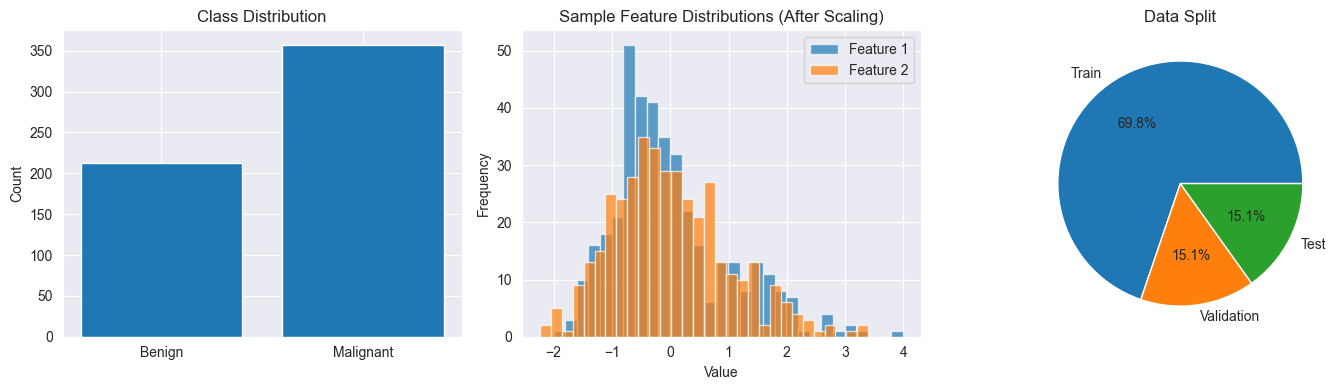

In [48]:
# Visualize data distribution
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.bar(['Benign', 'Malignant'], np.bincount(y))
plt.title('Class Distribution')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(X_train.T[:, 0], bins=30, alpha=0.7, label='Feature 1')
plt.hist(X_train.T[:, 1], bins=30, alpha=0.7, label='Feature 2')
plt.title('Sample Feature Distributions (After Scaling)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 3)
split_sizes = [X_train.shape[1], X_val.shape[1], X_test.shape[1]]
plt.pie(split_sizes, labels=['Train', 'Validation', 'Test'], autopct='%1.1f%%')
plt.title('Data Split')

plt.tight_layout()
plt.show()

## Part 6: Train Your Neural Network!

Now let's put everything together and train your from-scratch neural network!

**Network Architecture**:
- Input: 30 features
- Hidden Layer 1: 16 neurons with ReLU
- Hidden Layer 2: 8 neurons with ReLU
- Output: 1 neuron with Sigmoid

**Training Setup**:
- Loss: Binary Cross-Entropy
- Optimizer: Gradient Descent
- Learning Rate: 0.01
- Epochs: 2000

In [49]:
# Create the neural network
layer_architecture = [30, 16, 8, 1]  # [input, hidden1, hidden2, output]

nn = NeuralNetwork(
    layer_dims=layer_architecture,
    activation='relu',
    initialization='he'
)

print("Neural Network Created!")
print(f"Architecture: {layer_architecture}")
print(f"Hidden activation: ReLU")
print(f"Output activation: Sigmoid")
print(f"\nTotal parameters:")
total_params = 0
for key, value in nn.parameters.items():
    params = value.size
    total_params += params
    print(f"{key}: {value.shape} ({params} parameters)")
print(f"\nTotal trainable parameters: {total_params}")

Neural Network Created!
Architecture: [30, 16, 8, 1]
Hidden activation: ReLU
Output activation: Sigmoid

Total parameters:
W1: (16, 30) (480 parameters)
b1: (16, 1) (16 parameters)
W2: (8, 16) (128 parameters)
b2: (8, 1) (8 parameters)
W3: (1, 8) (8 parameters)
b3: (1, 1) (1 parameters)

Total trainable parameters: 641


In [50]:
# Train the network
print("Starting training...\n")

nn.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=2000,
    learning_rate=0.01,
    print_every=200
)

print("\nTraining complete!")

Starting training...

Epoch 200/2000 - Loss: 0.2253 - Acc: 91.94% - Val Loss: 0.1862 - Val Acc: 95.35%
Epoch 400/2000 - Loss: 0.1336 - Acc: 96.98% - Val Loss: 0.0996 - Val Acc: 97.67%
Epoch 600/2000 - Loss: 0.0922 - Acc: 97.98% - Val Loss: 0.0653 - Val Acc: 98.84%
Epoch 800/2000 - Loss: 0.0719 - Acc: 98.24% - Val Loss: 0.0487 - Val Acc: 98.84%
Epoch 1000/2000 - Loss: 0.0601 - Acc: 98.49% - Val Loss: 0.0391 - Val Acc: 100.00%
Epoch 1200/2000 - Loss: 0.0522 - Acc: 98.49% - Val Loss: 0.0328 - Val Acc: 100.00%
Epoch 1400/2000 - Loss: 0.0464 - Acc: 98.74% - Val Loss: 0.0286 - Val Acc: 100.00%
Epoch 1600/2000 - Loss: 0.0422 - Acc: 98.74% - Val Loss: 0.0253 - Val Acc: 100.00%
Epoch 1800/2000 - Loss: 0.0388 - Acc: 98.49% - Val Loss: 0.0226 - Val Acc: 100.00%
Epoch 2000/2000 - Loss: 0.0356 - Acc: 98.49% - Val Loss: 0.0204 - Val Acc: 100.00%

Training complete!


## Part 7: Evaluate and Visualize Results

Let's see how well your from-scratch neural network performs!

In [51]:
# Make predictions on test set
test_predictions, test_probabilities = nn.predict(X_test)
test_accuracy = nn.compute_accuracy(y_test, test_probabilities)

print("Test Set Performance:")
print(f"Accuracy: {test_accuracy:.2f}%")
print(f"\nSample predictions (first 10):")
print(f"True labels:  {y_test[0, :10]}")
print(f"Predictions:  {test_predictions[0, :10]}")
print(f"Probabilities: {test_probabilities[0, :10].round(3)}")

Test Set Performance:
Accuracy: 96.51%

Sample predictions (first 10):
True labels:  [0 0 0 1 0 1 1 0 0 1]
Predictions:  [0 0 0 1 0 1 1 0 0 1]
Probabilities: [0.028 0.    0.    1.    0.    0.994 0.63  0.024 0.001 0.989]


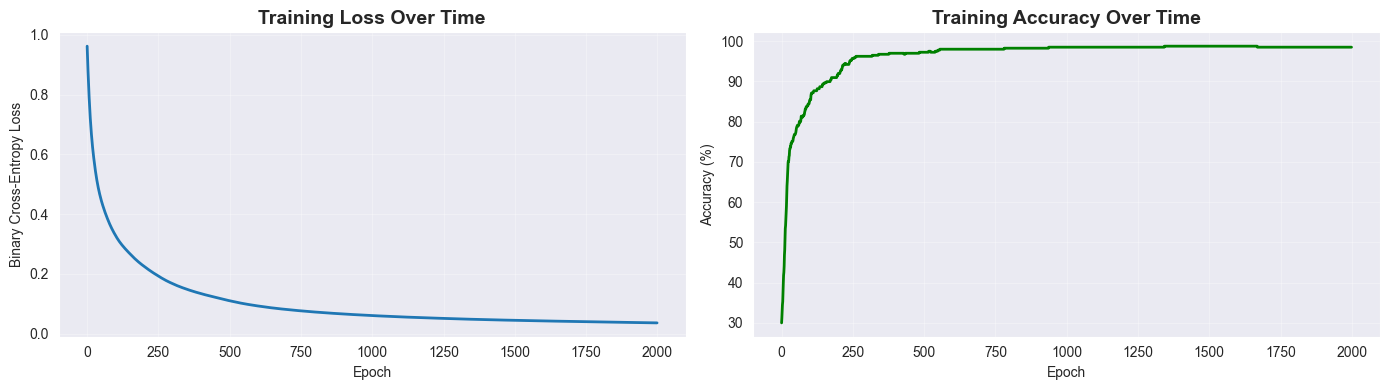

In [52]:
# Visualize training history
plt.figure(figsize=(14, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(nn.history['loss'], linewidth=2)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True, alpha=0.3)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(nn.history['accuracy'], linewidth=2, color='green')
plt.title('Training Accuracy Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

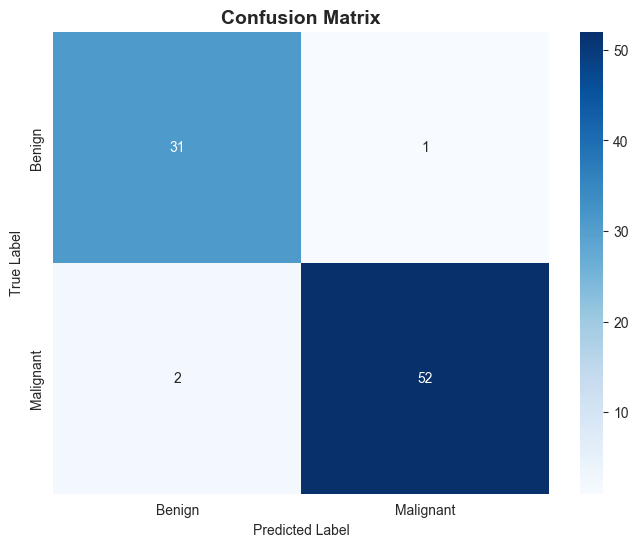


Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      0.97      0.95        32
   Malignant       0.98      0.96      0.97        54

    accuracy                           0.97        86
   macro avg       0.96      0.97      0.96        86
weighted avg       0.97      0.97      0.97        86



In [53]:
# Confusion Matrix shows us :
# 1. TN (True Negative): Predicted benign, actually benign ✓
# 2. TP (True Positive): Predicted malignant, actually malignant ✓
# 3. FP (False Positive): Predicted malignant, but actually benign ✗ (False alarm)
# 4. FN (False Negative): Predicted benign, but actually malignant ✗ (DANGEROUS!)
# Accuracy alone misleading:
#- Model A: 96% accurate, but misses 20% of cancers
#- Model B: 94% accurate, but only misses 2% of cancers
#- Model B is better! (Confusion matrix shows this)

cm = confusion_matrix(y_test.flatten(), test_predictions.flatten())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test.flatten(), test_predictions.flatten(), 
                          target_names=['Benign', 'Malignant']))

## Part 8: Experiment Time!

Now that you have a working neural network, try experimenting with:

1. **Different architectures**: Add more layers or change hidden layer sizes
2. **Learning rates**: Try 0.001, 0.01, 0.1
3. **Activation functions**: Switch between ReLU, sigmoid, tanh
4. **Initialization methods**: Compare 'random', 'xavier', 'he'
5. **Training epochs**: More or fewer iterations

Example experiments below:


Training with learning rate: 0.001
Epoch 500/2000 - Loss: 0.4450 - Acc: 77.08% - Val Loss: 0.4563 - Val Acc: 77.91%
Epoch 1000/2000 - Loss: 0.3277 - Acc: 85.39% - Val Loss: 0.3079 - Val Acc: 87.21%
Epoch 1500/2000 - Loss: 0.2671 - Acc: 89.67% - Val Loss: 0.2333 - Val Acc: 91.86%
Epoch 2000/2000 - Loss: 0.2246 - Acc: 91.94% - Val Loss: 0.1863 - Val Acc: 95.35%
Test Accuracy: 91.86%

Training with learning rate: 0.01
Epoch 500/2000 - Loss: 0.1098 - Acc: 97.23% - Val Loss: 0.0794 - Val Acc: 97.67%
Epoch 1000/2000 - Loss: 0.0601 - Acc: 98.49% - Val Loss: 0.0391 - Val Acc: 100.00%
Epoch 1500/2000 - Loss: 0.0442 - Acc: 98.74% - Val Loss: 0.0269 - Val Acc: 100.00%
Epoch 2000/2000 - Loss: 0.0356 - Acc: 98.49% - Val Loss: 0.0204 - Val Acc: 100.00%
Test Accuracy: 96.51%

Training with learning rate: 0.1
Epoch 500/2000 - Loss: 0.0153 - Acc: 99.75% - Val Loss: 0.0096 - Val Acc: 100.00%
Epoch 1000/2000 - Loss: 0.0062 - Acc: 100.00% - Val Loss: 0.0085 - Val Acc: 100.00%
Epoch 1500/2000 - Loss: 0.00

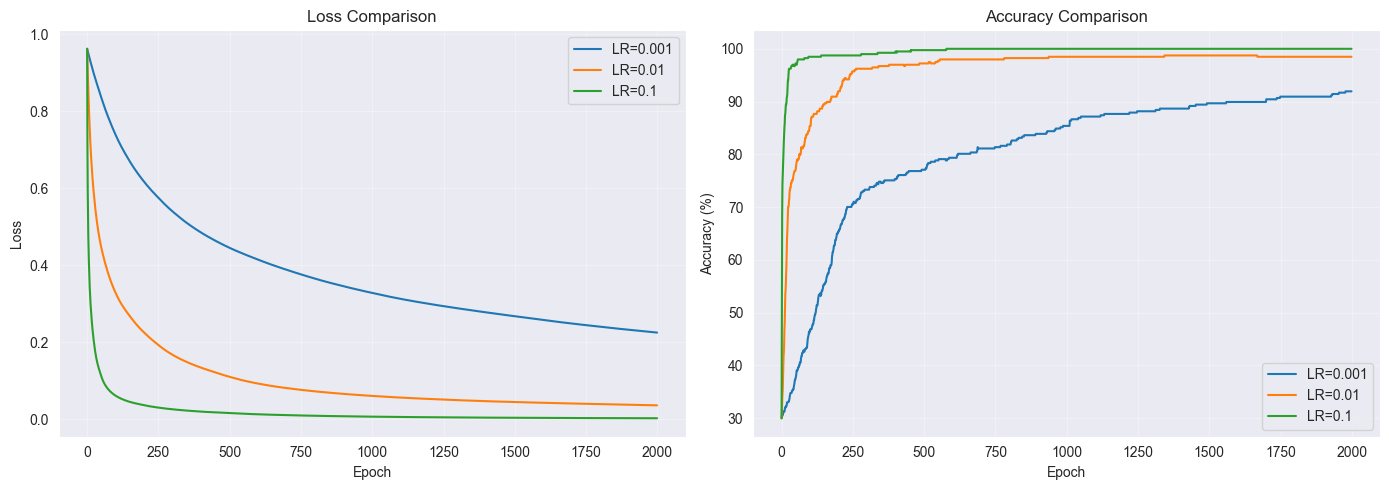

In [68]:
# EXPERIMENT 1: Different learning rates
learning_rates = [0.001, 0.01, 0.1]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    nn_exp = NeuralNetwork([30, 16, 8, 1], activation='relu', initialization='he')
    nn_exp.train(X_train, y_train, X_val, y_val, 
                 epochs=2000, learning_rate=lr, print_every=500)
    
    _, test_probs = nn_exp.predict(X_test)
    test_acc = nn_exp.compute_accuracy(y_test, test_probs)
    results[lr] = {'accuracy': test_acc, 'history': nn_exp.history}
    print(f"Test Accuracy: {test_acc:.2f}%")

# Plot comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for lr in learning_rates:
    plt.plot(results[lr]['history']['loss'], label=f'LR={lr}')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for lr in learning_rates:
    plt.plot(results[lr]['history']['accuracy'], label=f'LR={lr}')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Training architecture: [30, 8, 1]
Epoch 1500/1500 - Loss: 0.0877 - Acc: 97.48% - Val Loss: 0.0467 - Val Acc: 100.00%
Test Accuracy: 93.02%

Training architecture: [30, 16, 8, 1]
Epoch 1500/1500 - Loss: 0.0442 - Acc: 98.74% - Val Loss: 0.0269 - Val Acc: 100.00%
Test Accuracy: 96.51%

Training architecture: [30, 32, 16, 8, 1]
Epoch 1500/1500 - Loss: 0.0433 - Acc: 99.24% - Val Loss: 0.0146 - Val Acc: 100.00%
Test Accuracy: 94.19%


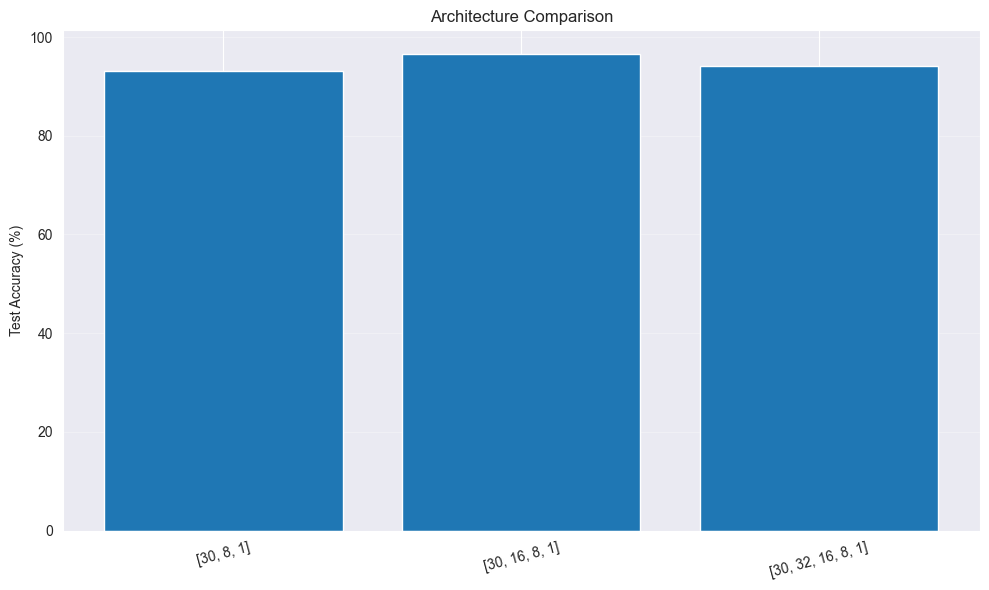

In [69]:
# EXPERIMENT 2: Different architectures
architectures = [
    [30, 8, 1],          # Shallow network
    [30, 16, 8, 1],      # Medium network (our original)
    [30, 32, 16, 8, 1],  # Deep network
]

arch_results = {}

for arch in architectures:
    arch_name = str(arch)
    print(f"\nTraining architecture: {arch}")
    nn_arch = NeuralNetwork(arch, activation='relu', initialization='he')
    nn_arch.train(X_train, y_train, X_val, y_val, 
                  epochs=1500, learning_rate=0.01, print_every=1500)
    
    _, test_probs = nn_arch.predict(X_test)
    test_acc = nn_arch.compute_accuracy(y_test, test_probs)
    arch_results[arch_name] = test_acc
    print(f"Test Accuracy: {test_acc:.2f}%")

# Plot results
plt.figure(figsize=(10, 6))
plt.bar(range(len(arch_results)), list(arch_results.values()))
plt.xticks(range(len(arch_results)), list(arch_results.keys()), rotation=15)
plt.ylabel('Test Accuracy (%)')
plt.title('Architecture Comparison')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Summary & Key Takeaways

Congratulations! You've built a neural network from scratch. Here's what you learned:

### **Core Concepts**:
1. **Activation Functions**: Add non-linearity (ReLU, Sigmoid, Tanh)
2. **Forward Propagation**: Pass data through layers to get predictions
3. **Loss Functions**: Measure prediction error (BCE for classification)
4. **Backpropagation**: Use chain rule to compute gradients
5. **Gradient Descent**: Update weights to minimize loss

### **Key Equations**:
- **Forward**: `A = activation(W @ X + b)`
- **Loss**: `L = -1/m * Σ[y*log(ŷ) + (1-y)*log(1-ŷ)]`
- **Backward**: Chain rule through all layers
- **Update**: `W = W - α * dW`

### **What's Next**:
- Implement mini-batch gradient descent
- Add momentum and Adam optimizer
- Try regularization (L2, dropout)
- Experiment with different datasets
- Build CNNs for image data

### **Comparison to PyTorch**:
Everything you did manually (forward prop, backprop, gradient descent) is automated in frameworks like PyTorch. But now you understand what's happening under the hood!